## K-Means Clustering

# 1. Read and visualise the data

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [87]:
#help(KMeans)

In [88]:
# read the dataset
cricket_df = pd.read_csv("Cricket.csv", sep=",", encoding="ISO-8859-1", header=0)
cricket_df.head()

,Player,Span,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0
0,SR Tendulkar (INDIA),1989-2012,463,452,41,18426,200*,44.83,21367,86.23,49,96,20
1,KC Sangakkara (Asia/ICC/SL),2000-2015,404,380,41,14234,169,41.98,18048,78.86,25,93,15
2,RT Ponting (AUS/ICC),1995-2012,375,365,39,13704,164,42.03,17046,80.39,30,82,20
3,ST Jayasuriya (Asia/SL),1989-2011,445,433,18,13430,189,32.36,14725,91.20,28,68,34
4,DPMD Jayawardene (Asia/SL),1998-2015,448,418,39,12650,144,33.37,16020,78.96,19,77,28


In [89]:
# basics of the df
cricket_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  79 non-null     object 
 1   Span    79 non-null     object 
 2   Mat     79 non-null     int64  
 3   Inns    79 non-null     int64  
 4   NO      79 non-null     int64  
 5   Runs    79 non-null     int64  
 6   HS      79 non-null     object 
 7   Ave     79 non-null     float64
 8   BF      79 non-null     int64  
 9   SR      79 non-null     float64
 10  100     79 non-null     int64  
 11  50      79 non-null     int64  
 12  0       79 non-null     int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 8.1+ KB


In [90]:
nameCol = cricket_df['Player']
nameCol

0            SR Tendulkar (INDIA)
1     KC Sangakkara (Asia/ICC/SL)
2            RT Ponting (AUS/ICC)
3         ST Jayasuriya (Asia/SL)
4      DPMD Jayawardene (Asia/SL)
                 ...             
74              CG Greenidge (WI)
75            Misbah-ul-Haq (PAK)
76           PD Collingwood (ENG)
77                A Symonds (AUS)
78        Abdul Razzaq (Asia/PAK)
Name: Player, Length: 79, dtype: object

# 2. Clean the data

In [91]:
cricket_df.columns
#['Span', 'Mat', 'Inns', 'NO', 'Runs', 'HS', 'BF', '100', '50', '0']
cricket_df = cricket_df.drop(['Player', 'Span', 'Mat', 'Inns', 'NO', 'Runs', 'HS', 'BF', '100', '50', '0'], axis=1)

In [92]:
cricket_df

,Ave,SR
0,44.83,86.23
1,41.98,78.86
2,42.03,80.39
3,32.36,91.20
4,33.37,78.96
...,...,...
74,45.03,64.92
75,43.40,73.75
76,35.36,76.98
77,39.75,92.44


# 3. Prepare the data for modelling

- R (Recency): Number of days since last purchase
- F (Frequency): Number of tracsactions
- M (Monetary): Total amount of transactions (revenue contributed)

In [93]:
# recency
#last_purchase = retail_df.groupby('CustomerID')['diff'].min()
#last_purchase = last_purchase.reset_index()
#last_purchase.head()

In [94]:
# two types of outliers:
# - statistical
# - domain specific

In [95]:
# 2. rescaling

# instantiate
scaler = StandardScaler()

# fit_transform
cricket_df_scaled = scaler.fit_transform(cricket_df)
cricket_df_scaled.shape

(79, 2)

In [96]:
cricket_df_scaled

array([[ 1.07229395,  0.70315153],
       [ 0.58772461, -0.0441395 ],
       [ 0.59622582,  0.1109969 ],
       [-1.04790945,  1.20709133],
       [-0.87618487, -0.03399986],
       [ 0.16946476, -0.51259058],
       [ 0.99238251, -0.64947564],
       [ 0.42450125, -0.56734461],
       [ 0.108256  , -0.8167796 ],
       [ 0.33268811,  0.02176813],
       [ 0.12695867,  0.70315153],
       [ 0.54181804, -0.42538973],
       [-0.44772356,  1.78910632],
       [ 2.17575185,  0.95258652],
       [-0.2725985 , -0.53489778],
       [ 2.5549061 ,  2.1247282 ],
       [-0.61604765,  0.1860302 ],
       [-0.20288853,  0.58958763],
       [ 0.11675721,  0.13938788],
       [ 0.52311536, -0.86747777],
       [-0.3355075 ,  0.84916225],
       [ 0.48400977, -1.64315977],
       [-0.16208269, -1.17369472],
       [ 0.14056062, -0.24287632],
       [-0.590544  ,  2.53842527],
       [ 2.62121559,  1.1857981 ],
       [-0.40691772,  0.4020044 ],
       [-2.5424233 ,  3.82311689],
       [-1.04110847,

In [97]:
cricket_df_scaled = pd.DataFrame(cricket_df_scaled)
cricket_df_scaled.columns = ['Ave', 'SR']
cricket_df_scaled.head()

,Ave,SR
0,1.072294,0.703152
1,0.587725,-0.044139
2,0.596226,0.110997
3,-1.047909,1.207091
4,-0.876185,-0.034000


# 4. Modelling

In [98]:
# k-means with some arbitrary k
kmeans = KMeans(n_clusters=4, random_state=100, max_iter=50)
kmeans.fit(cricket_df_scaled)

KMeans(max_iter=50, n_clusters=4, random_state=100)

In [99]:
kmeans.labels_

array([3, 1, 1, 0, 2, 1, 1, 1, 1, 1, 0, 1, 0, 3, 2, 3, 2, 0, 1, 1, 0, 1,
       2, 1, 0, 3, 2, 0, 2, 1, 2, 2, 1, 2, 3, 2, 2, 1, 3, 1, 2, 2, 3, 2,
       2, 2, 1, 2, 2, 1, 0, 1, 2, 2, 2, 2, 1, 0, 2, 0, 2, 0, 1, 3, 3, 1,
       1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2, 0, 2])

In [100]:
# help(KMeans)
cricket_df_scaled.shape

(79, 2)

In [101]:
# Using DataFrame.insert() to add a column 
cricket_df_scaled.insert(0, "ClusterID", list(kmeans.labels_), True) 


In [102]:
list(nameCol)

['SR Tendulkar\xa0(INDIA)',
 'KC Sangakkara\xa0(Asia/ICC/SL)',
 'RT Ponting\xa0(AUS/ICC)',
 'ST Jayasuriya\xa0(Asia/SL)',
 'DPMD Jayawardene\xa0(Asia/SL)',
 'Inzamam-ul-Haq\xa0(Asia/PAK)',
 'JH Kallis\xa0(Afr/ICC/SA)',
 'SC Ganguly\xa0(Asia/INDIA)',
 'R Dravid\xa0(Asia/ICC/INDIA)',
 'BC Lara\xa0(ICC/WI)',
 'TM Dilshan\xa0(SL)',
 'Mohammad Yousuf\xa0(Asia/PAK)',
 'AC Gilchrist\xa0(AUS/ICC)',
 'MS Dhoni\xa0(Asia/INDIA)',
 'M Azharuddin\xa0(INDIA)',
 'AB de Villiers\xa0(Afr/SA)',
 'PA de Silva\xa0(SL)',
 'CH Gayle\xa0(ICC/WI)',
 'Saeed Anwar\xa0(PAK)',
 'S Chanderpaul\xa0(WI)',
 'Yuvraj Singh\xa0(Asia/INDIA)',
 'DL Haynes\xa0(WI)',
 'MS Atapattu\xa0(SL)',
 'ME Waugh\xa0(AUS)',
 'V Sehwag\xa0(Asia/ICC/INDIA)',
 'V Kohli\xa0(INDIA)',
 'HH Gibbs\xa0(SA)',
 'Shahid Afridi\xa0(Asia/ICC/PAK)',
 'SP Fleming\xa0(ICC/NZ)',
 'MJ Clarke\xa0(AUS)',
 'SR Waugh\xa0(AUS)',
 'A Ranatunga\xa0(SL)',
 'Javed Miandad\xa0(PAK)',
 'Younis Khan\xa0(PAK)',
 'HM Amla\xa0(SA)',
 'Saleem Malik\xa0(PAK)',
 'NJ Astle

In [103]:
cricket_df_scaled.insert(0, "Name", list(nameCol), True) 

In [104]:
cricket_df_scaled.head()
final_df = cricket_df_scaled.sort_values(by=['ClusterID'], ascending=False)

In [106]:
final_df.head(80)

,Name,ClusterID,Ave,SR
0,SR Tendulkar (INDIA),3,1.072294,0.703152
64,MEK Hussey (AUS),3,1.636775,0.797450
38,MG Bevan (AUS),3,2.560007,-0.520702
25,V Kohli (INDIA),3,2.621216,1.185798
42,IVA Richards (WI),3,1.441247,1.105695
...,...,...,...,...
50,BB McCullum (NZ),0,-1.379457,1.731310
61,SK Raina (INDIA),0,-0.520834,1.466666
10,TM Dilshan (SL),0,0.126959,0.703152
59,SR Watson (AUS),0,0.342890,1.130030


In [107]:
pd.set_option('display.max_rows', None)
print(final_df)

                            Name  ClusterID       Ave        SR
0           SR Tendulkar (INDIA)          3  1.072294  0.703152
64              MEK Hussey (AUS)          3  1.636775  0.797450
38                MG Bevan (AUS)          3  2.560007 -0.520702
25               V Kohli (INDIA)          3  2.621216  1.185798
42             IVA Richards (WI)          3  1.441247  1.105695
13         MS Dhoni (Asia/INDIA)          3  2.175752  0.952587
63               MJ Guptill (NZ)          3  0.812157  0.855246
15       AB de Villiers (Afr/SA)          3  2.554906  2.124728
34                  HM Amla (SA)          3  1.993826  0.989089
45               AR Border (AUS)          2 -1.343752 -0.798528
35            Saleem Malik (PAK)          2 -0.959497 -0.292561
36                 NJ Astle (NZ)          2 -0.612647 -0.674825
76          PD Collingwood (ENG)          2 -0.537836 -0.234765
40                A Flower (ZIM)          2 -0.541237 -0.477102
73              RS Mahanama (SL)        

## Finding the Optimal Number of Clusters

### SSD

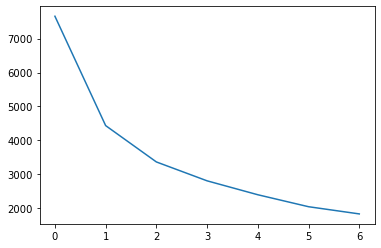

In [27]:
# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)

### Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [28]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    
    

For n_clusters=2, the silhouette score is 0.5415858652525395
For n_clusters=3, the silhouette score is 0.5084896296141937
For n_clusters=4, the silhouette score is 0.47782241003860476
For n_clusters=5, the silhouette score is 0.4662700564189704
For n_clusters=6, the silhouette score is 0.4176921719944174
For n_clusters=7, the silhouette score is 0.4172224044214832
For n_clusters=8, the silhouette score is 0.38895686721756584


In [29]:
# final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [30]:
kmeans.labels_

array([1, 2, 0, ..., 1, 0, 0])

In [31]:
# assign the label
grouped_df['cluster_id'] = kmeans.labels_
grouped_df.head()

,CustomerID,amount,frequency,recency,cluster_id
0,12346.0,0.00,2,325,1
1,12347.0,4310.00,182,1,2
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,1


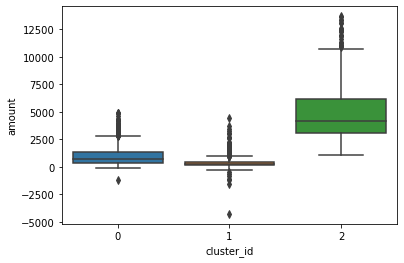

In [32]:
# plot
sns.boxplot(x='cluster_id', y='amount', data=grouped_df)

## Hierarchical Clustering

In [33]:
rfm_df_scaled.head()

,amount,frequency,recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


In [34]:
grouped_df.head()

,CustomerID,amount,frequency,recency,cluster_id
0,12346.0,0.00,2,325,1
1,12347.0,4310.00,182,1,2
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,1


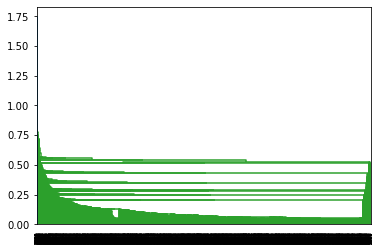

In [35]:
# single linkage
mergings = linkage(rfm_df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

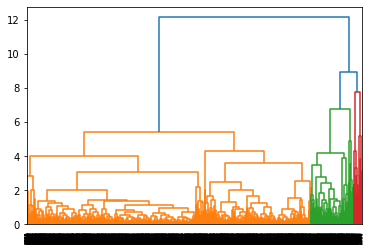

In [36]:
# complete linkage
mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [37]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 1, 0, ..., 0, 0, 0])

In [38]:
# assign cluster labels
grouped_df['cluster_labels'] = cluster_labels
grouped_df.head()

,CustomerID,amount,frequency,recency,cluster_id,cluster_labels
0,12346.0,0.00,2,325,1,0
1,12347.0,4310.00,182,1,2,1
2,12348.0,1797.24,31,74,0,0
3,12349.0,1757.55,73,18,0,0
4,12350.0,334.40,17,309,1,0


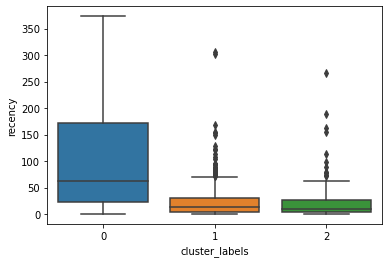

In [39]:
# plots
sns.boxplot(x='cluster_labels', y='recency', data=grouped_df)

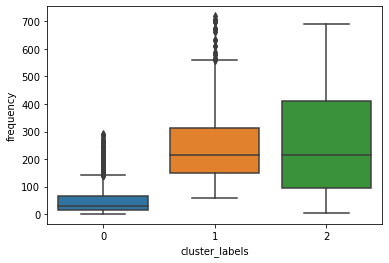

In [40]:
# plots
sns.boxplot(x='cluster_labels', y='frequency', data=grouped_df)

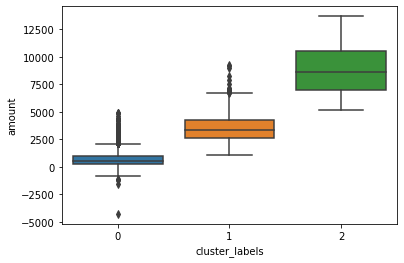

In [41]:
# plots
sns.boxplot(x='cluster_labels', y='amount', data=grouped_df)

In [42]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [43]:
#First convert the numpy array that you have to a dataframe
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['amount', 'frequency', 'recency']

In [44]:
#Use the Hopkins Statistic function by passing the above dataframe as a paramter
hopkins(rfm_df_scaled)

0.9505174153131861

## Hierarchical clustering

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [109]:
# read the dataset
cricket_df = pd.read_csv("Cricket.csv", sep=",", encoding="ISO-8859-1", header=0)
cricket_df.head()

,Player,Span,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0
0,SR Tendulkar (INDIA),1989-2012,463,452,41,18426,200*,44.83,21367,86.23,49,96,20
1,KC Sangakkara (Asia/ICC/SL),2000-2015,404,380,41,14234,169,41.98,18048,78.86,25,93,15
2,RT Ponting (AUS/ICC),1995-2012,375,365,39,13704,164,42.03,17046,80.39,30,82,20
3,ST Jayasuriya (Asia/SL),1989-2011,445,433,18,13430,189,32.36,14725,91.20,28,68,34
4,DPMD Jayawardene (Asia/SL),1998-2015,448,418,39,12650,144,33.37,16020,78.96,19,77,28


In [110]:
nameCol = cricket_df['Player']
nameCol

0             SR Tendulkar (INDIA)
1      KC Sangakkara (Asia/ICC/SL)
2             RT Ponting (AUS/ICC)
3          ST Jayasuriya (Asia/SL)
4       DPMD Jayawardene (Asia/SL)
5        Inzamam-ul-Haq (Asia/PAK)
6           JH Kallis (Afr/ICC/SA)
7          SC Ganguly (Asia/INDIA)
8        R Dravid (Asia/ICC/INDIA)
9                 BC Lara (ICC/WI)
10                 TM Dilshan (SL)
11      Mohammad Yousuf (Asia/PAK)
12          AC Gilchrist (AUS/ICC)
13           MS Dhoni (Asia/INDIA)
14            M Azharuddin (INDIA)
15         AB de Villiers (Afr/SA)
16                PA de Silva (SL)
17               CH Gayle (ICC/WI)
18               Saeed Anwar (PAK)
19              S Chanderpaul (WI)
20       Yuvraj Singh (Asia/INDIA)
21                  DL Haynes (WI)
22                MS Atapattu (SL)
23                  ME Waugh (AUS)
24       V Sehwag (Asia/ICC/INDIA)
25                 V Kohli (INDIA)
26                   HH Gibbs (SA)
27    Shahid Afridi (Asia/ICC/PAK)
28             SP Fl

In [111]:
cricket_df.columns
#['Span', 'Mat', 'Inns', 'NO', 'Runs', 'HS', 'BF', '100', '50', '0']
cricket_df = cricket_df.drop(['Player', 'Span', 'Mat', 'Inns', 'NO', 'Runs', 'HS', 'BF', '100', '50', '0'], axis=1)

In [112]:
# 2. rescaling

# instantiate
scaler = StandardScaler()

# fit_transform
cricket_df_scaled = scaler.fit_transform(cricket_df)
cricket_df_scaled.shape

(79, 2)

In [113]:
cricket_df_scaled = pd.DataFrame(cricket_df_scaled)
cricket_df_scaled.columns = ['Ave', 'SR']
cricket_df_scaled.head()

,Ave,SR
0,1.072294,0.703152
1,0.587725,-0.044139
2,0.596226,0.110997
3,-1.047909,1.207091
4,-0.876185,-0.034000


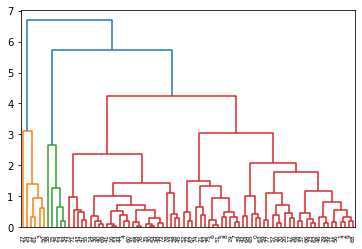

In [114]:
# complete linkage
mergings = linkage(cricket_df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [115]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=4).reshape(-1, )
cluster_labels

array([0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 3, 2, 3, 2, 0, 0, 0, 0, 0,
       0, 0, 1, 3, 0, 1, 2, 0, 2, 2, 0, 2, 3, 2, 2, 0, 3, 0, 2, 2, 0, 2,
       2, 2, 0, 2, 2, 0, 1, 0, 0, 2, 2, 2, 0, 0, 2, 0, 2, 1, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 2, 0, 2])

In [116]:
# assign cluster labels
cricket_df_scaled['cluster_labels'] = cluster_labels
cricket_df_scaled.head()

,Ave,SR,cluster_labels
0,1.072294,0.703152,0
1,0.587725,-0.044139,0
2,0.596226,0.110997,0
3,-1.047909,1.207091,1
4,-0.876185,-0.034000,2


In [117]:
cricket_df_scaled.insert(0, "Name", list(nameCol), True) 

In [119]:
cricket_df_scaled.head()
final_df = cricket_df_scaled.sort_values(by=['cluster_labels'], ascending=False)

In [120]:
final_df.head(80)

,Name,Ave,SR,cluster_labels
38,MG Bevan (AUS),2.560007,-0.520702,3
34,HM Amla (SA),1.993826,0.989089,3
15,AB de Villiers (Afr/SA),2.554906,2.124728,3
13,MS Dhoni (Asia/INDIA),2.175752,0.952587,3
25,V Kohli (INDIA),2.621216,1.185798,3
36,NJ Astle (NZ),-0.612647,-0.674825,2
28,SP Fleming (ICC/NZ),-1.041108,-0.791431,2
30,SR Waugh (AUS),-0.956096,-0.343259,2
31,A Ranatunga (SL),-0.456225,-0.141480,2
60,Tamim Iqbal (BDESH),-0.704460,-0.099907,2
